# Mini-Projet : Segmentation d'images TEP par classification spectrale

L'objectif de ce TP est de segmenter des images de Tomographie par Emission de Positons (TEP)  via des méthodes de classification non supervisée et, en particulier, une méthode de classification spectrale. 

## Principe de l'imagerie TEP 

La Tomographie par Emission de Positons (ou TEP) est une technique d'imagerie médicale fonctionnelle quantitative permettant de visualiser les activités du métabolisme. Les données TEP forment une sèquence *3D + t* qui traduit l'évolution de la radioactivité dans le temps du volume correspondant au champ de vue de l'appareil de mesure.


<img src="./PrincipePET.png" width="600" height="300">



Nous nous intéressons, dans ce TP, à la segmentation d'une coupe transverse et sagittale du cerveau, réprésentée respectivement à gauche et à droite sur la figure ci-dessous. Le nombre de classes à retrouver correspond aux différentes couleurs représentées sur la figure. Ici, l'information géométrique (position de chaque pixel dans l'image) n'est pas prise en compte.

<img src="./zubal_fig3.png" width="600" height="300">


Ce mini-projet se décompose en 5 parties:
- **Partie I :** implémentation de la classification spectrale avec exemple jouet 
- **Partie II :** application de la classification spectrale sur les protils temporels TACs 
- **Partie III :** classification par Kmeans puis par réduction de dimension ACP+Kmeans
- **Partie IV :** évaluation des résultats
- **Partie V :** votre analyse



In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

## Partie I : Classification spectrale

Parmi les méthodes de partitionnement non supervisé, les méthodes à noyaux reposent sur le même principe : elles utilisent des relations d'adjacence (d'affinité) entre tous les couples de points sans a priori sur les formes des classes. Nous nous concentrons sur l'algorithme de classification spectrale décrit ci-dessous, très simple à implémenter. La mesure d'affinité utilisée est l'affinité gaussienne qui dépend d'un paramètre noté $\sigma$.


On dispose d'un ensemble  de données $S=\{x_i\}_{i=1,..,n}\in \mathbb{R}^p$ composé de $n$ points de dimension $p$ et d'un nombre de classes, noté $k$, à obtenir. La méthode de classification spectrale  consiste à extraire les vecteurs propres associés aux plus grandes valeurs propres d'une matrice d'affinité normalisée. Ces vecteurs propres constituent ensuite un espace de dimension réduite dans lequel les données transformées seront linéairement séparables.  

<img src="files/AlgoSC.png" width="600" height="300">
<img src="files/SCexple.png" width="600" height="300">


### Travail demandé

- Ecrire la fonction **classification_spectrale** implantant l'algorithme 1. Cette fonction en entrée les données Input de l'algorithme.
- Tester la fonction sur le jeu de données *ToyExample.mat* et tester différentes valeurs de paramètres $\sigma$. Les résultats sont-ils similaires ?


### Fonctions python utiles
- exp (numpy)
- norm (linalg)
- inv (linalg)
- eig (linalg)
- KMeans (sklearn)

In [ ]:
def classification_spectrale(Data,k,sigma):
    Data=np.asarray(Data)
    k=int(k)
    
    # construction de la matrice affinité
    n = len(Data)
    matA = np.zeros((n,n))
    #Matrice n x n

    for i in range(0,n):
      for j in range(0,n):
        if i != j :
          alph = pow(np.linalg.norm(Data[i]-Data[j]),2)
          matA[i,j] = np.exp( -1*alph/(2*pow(sigma,2)) )
    
    # Normalisation de la matrice affinité    
    L = np.zeros((n,n))
    for i in range(0,n):
      for j in range(0,n):
        L[i,i] += matA[i,j]
    L = scipy.linalg.inv(L)  
    L = np.matmul(L, matA)
    
    # Calcul des vecteurs propres de L
    valPropL,vecPropL = np.linalg.eig(L)
    
    #Extraction des k + grands vecteurs propres
    indValPropSorted = np.argsort(valPropL, axis=0)[::-1]
    X = vecPropL[:,indValPropSorted[:k]]

    # Normalisation des lignes de X
    Sum_X_2 = np.sum(pow(X,2), axis=1, keepdims=True)
    Y = X / np.sqrt(Sum_X_2)
    
    #Kmeans sur l'espace spectral
    PartitionSC=np.zeros(Y.shape)
    PartitionSC = KMeans(n_clusters=k,random_state=0).fit_predict(Y)
    
    
    return PartitionSC

### Application : toy example

-------------------------------


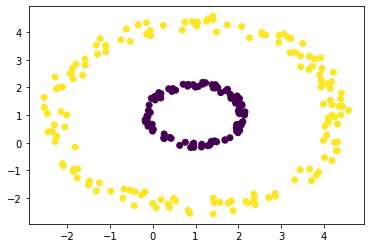

In [ ]:
matJouet = scipy.io.loadmat('ToyExample.mat')

ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet=np.asarray(ExpleJouet)

# Visualisation du jeu de données 
#plt.plot(ExpleJouet[:,0],ExpleJouet[:,1],'.')

print("-------------------------------")

classmp = classification_spectrale(ExpleJouet, 2, 0.2)

# Classification du jeu de données
plt.scatter(ExpleJouet[:,0],ExpleJouet[:,1],c=classmp)
#kmtest = KMeans(n_clusters=2,random_state=0).fit_predict(ExpleJouet)
#plt.scatter(ExpleJouet[:,0],ExpleJouet[:,1],c=kmtest)
#plt.scatter(classmp.cluster_centers_[:, 0], classmp.cluster_centers_[:, 1], c='red')
# Visualisation des classes
plt.show()

# Partie II : application de la classification spectrale sur les protils temporels TACs  

La segmentation des images TEP repose donc sur une classification de profils temporels très bruités sans disposer de connaissance a priori.  Ces profils temporels s'appellent des courbes Temps-Activité (notées TAC pour *Time Activity Curves*). Comme ils traduisent l'évolution de la radioactivité, elles comportent principalement 2 phases : une phase de croissance  suivie d'une phase de décroissance. Suivant les tissus, les profils temporels vont présenter  différentes amplitudes et des phases de croissance et de décroissance de durées plus ou moins longues. 

La simulation numérique est couramment utilisée dans le domaine du traitement d'image. Elle
constitue une aide précieuse pour le développement et l'évaluation de méthodes car elle permet de
disposer d'une vérité terrain à laquelle on va comparer les résultats obtenus. Un exemple de simulation de TACs est représenté sur la figure suivante

Dans l'imagerie médicale, ces simulations sont généralement effectuées selon la méthode Monte-Carlo, particulièrement adaptées à la physique nucléaire à
cause de la nature stochastique des processus d'émission, de transport et de détection.

<img src="files/TAC_simu_reel.png" width="800" height="400">


On dispose de données temporelles simulées (séquences de 20 instants) d'une coupe transverse et d'une coupe sagittale de taille $64\times 54$ (représentées sur la figure ci-dessus) que l'on souhaite segmenter sans prendre en compte l'information géométrique. On dispose aussi de la vérité terrain c'est-à-dire de la segmentation de ces coupes avant simulation. Ces matrices sont stockées respectivement dans les fichiers *DataTAC_S.mat* et *DataTAC_T.mat*.



Nombre de TAC de la coupe Sagittale : (3456, 20)
Nombre de TAC de la coupe Sagittale : (3456, 20)


Text(0.5, 1.0, 'TAC de Coupe Transverse')

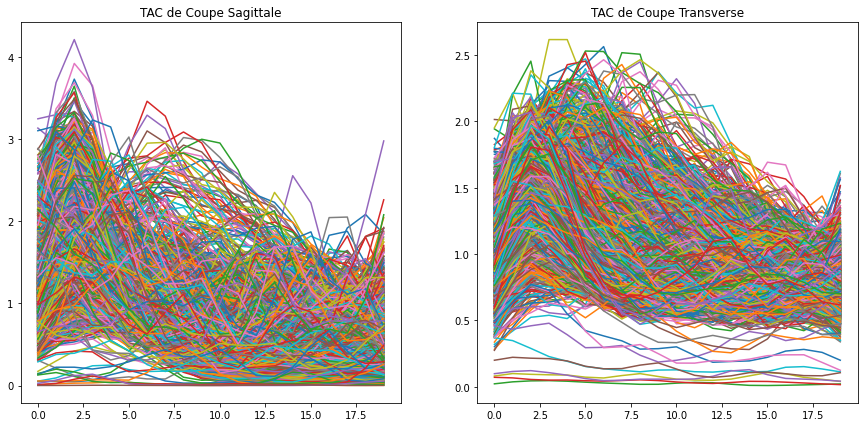

In [ ]:
# Chargement de la coupe sagittale
matS = scipy.io.loadmat('DataTAC_S.mat')
data_S = pd.DataFrame(matS['DataTAC_S'])

print('Nombre de TAC de la coupe Sagittale :' ,data_S.shape)

# Chargement de la coupe transverse
matT = scipy.io.loadmat('DataTAC_T.mat')
data_T = pd.DataFrame(matT['DataTAC_T'])

print('Nombre de TAC de la coupe Sagittale :', data_T.shape)

# Affichage des TAC des deux coupes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(data_S.T)
axs[0].set_title('TAC de Coupe Sagittale')
axs[1].plot(data_T.T)
axs[1].set_title('TAC de Coupe Transverse')


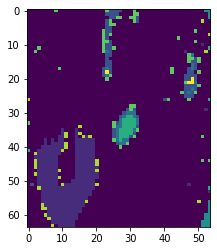

In [ ]:
from sklearn.cluster import SpectralClustering
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 9 classes
PartitionSC_S=np.zeros((3456))
PartitionSC_S = classification_spectrale(data_S,9,0.2)

# Redimensionnement de la partition de la coupe saggitale en (54,64)
ImSagittaleSC=np.reshape(PartitionSC_S,((54,64)))
plt.imshow(ImSagittaleSC.T)

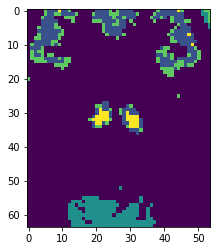

In [ ]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 5 classes

PartitionSC_T=np.zeros((3456))
PartitionSC_T = classification_spectrale(data_T,5,0.6)

# Redimensionnement de la partition de la coupe saggitale
ImTransverseSC=np.reshape(PartitionSC_T,(54,64))

plt.imshow(ImTransverseSC.T)


# Partie III : comparaison avec  kmeans (+ ACP)

- Réaliser une classification avec le kmeans de sklearn
- Tester aussi une réduction de dimension par ACP comme étape de prétraitement qui conserverait 95% de l'information

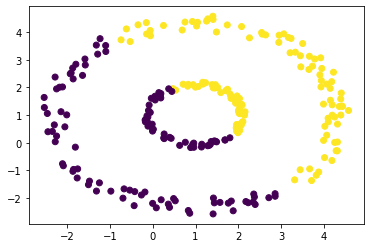

In [ ]:
# Tester Kmeans avec l'exemple jouet et afficher le résultat 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

matJouet = scipy.io.loadmat('ToyExample.mat')

ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet=np.asarray(ExpleJouet)


#ACP
def pcaRed(data,nbComponent):
  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(data)
  pca = PCA(nbComponent)
  principalComponents = pca.fit_transform(data_scaled)
  #print((pca.explained_variance_ratio_.sum())*100)
  return principalComponents

pcaRes = pcaRed(ExpleJouet,2)

#KMeans
pcaRes = KMeans(n_clusters=2).fit_predict(pcaRes)

#test sur l'exemple Jouet
plt.scatter(ExpleJouet[:,0],ExpleJouet[:,1],c=pcaRes)
plt.show()


Nombre de TAC de la coupe Sagittale : (3456, 20)


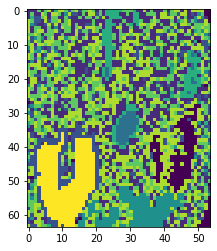

In [ ]:
# Tester sur les TACS
# Chargement de la coupe sagittale
matS = scipy.io.loadmat('DataTAC_S.mat')
data_S = pd.DataFrame(matS['DataTAC_S'])

print('Nombre de TAC de la coupe Sagittale :' ,data_S.shape)

# Chargement de la coupe transverse
matT = scipy.io.loadmat('DataTAC_T.mat')
data_T = pd.DataFrame(matT['DataTAC_T'])

# Test de PCA sur image sagittale de taille (54,64) comprenant 9 classes
pcaRes = pcaRed(data_S,6)
PartitionKM_S = KMeans(n_clusters=9).fit_predict(pcaRes)

ImSagittaleKM=np.reshape(PartitionKM_S,((54,64)))
plt.imshow(ImSagittaleKM.T)

# Test de PCA sur image sagittale de taille (54,64) comprenant 5 classes
pcaRes = pcaRed(data_T,7)
PartitionKM_T = KMeans(n_clusters=5).fit_predict(pcaRes)

ImTransverseKM = np.reshape(PartitionKM_T,((54,64)))
#plt.imshow(ImTransverseKM.T)

# Partie IV : Comparaison avec vérité terrain


En utilisant la vérité terrain des coupes (repectivement les matrices *ImageROI_DataSagittale*, *Image_ROI_DataTransverse*, analyser vos résultats et améliorer les.


<img src="files/VeriteTerrain.png" width="600" height="300">


Text(0.5, 1.05, 'Partition kmeans+pca')

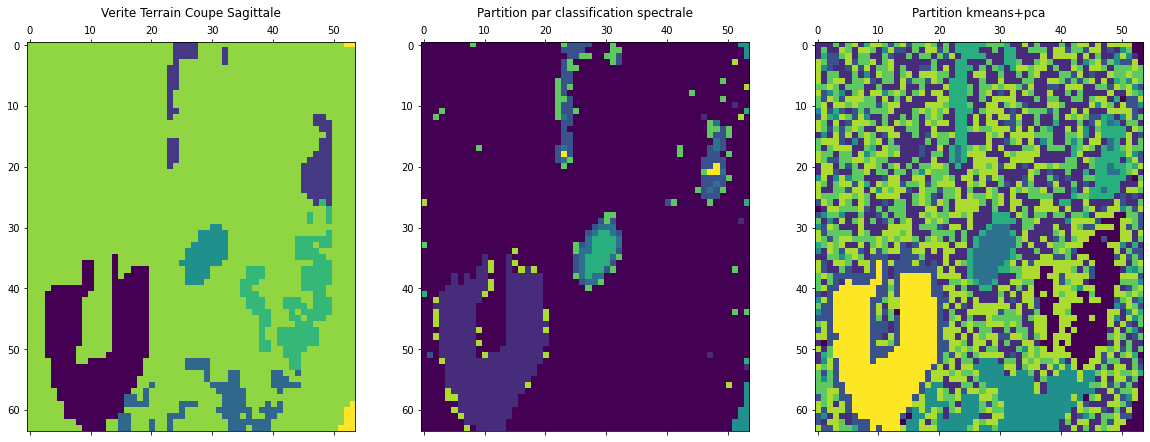

In [ ]:
dataROISagit= scipy.io.loadmat('ImageROI_DataSagittale.mat') 
dataROI_S = pd.DataFrame(dataROISagit['Image_ROI_S'])

# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_S)
axs[0].set_title('Verite Terrain Coupe Sagittale')
axs[1].matshow(ImSagittaleSC.T)
axs[1].set_title('Partition par classification spectrale')
axs[2].matshow(ImSagittaleKM.T)
axs[2].set_title('Partition kmeans+pca')


Text(0.5, 1.05, 'Partition kmeans+pca')

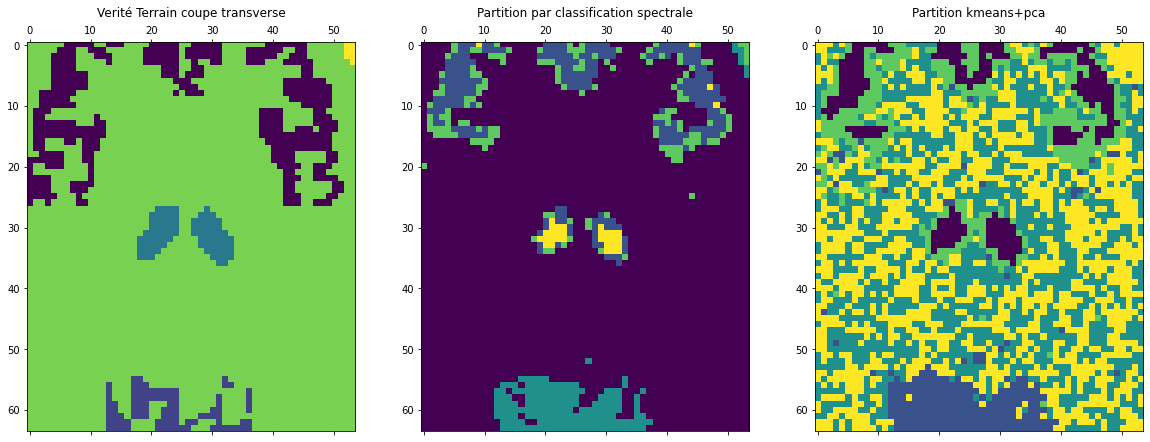

In [ ]:
dataROITrans= scipy.io.loadmat('ImageROI_DataTransverse.mat') 
dataROI_T = pd.DataFrame(dataROITrans['Image_ROI_T'])


# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_T)
axs[0].set_title('Verité Terrain coupe transverse')
axs[1].matshow(ImTransverseSC.T)
axs[1].set_title('Partition par classification spectrale')
axs[2].matshow(ImTransverseKM.T) # à modifier par Image issue du Kmeans
axs[2].set_title('Partition kmeans+pca')


## Calcul de mesures de précision et rappel 

**Précision :** évalue l'exactitude des prédictions positives
$$Precision=\frac{TP}{TP+FP}$$
**Rappel :** évalue le taux d'observations positives ayant été correctement détectées par le classifieur
$$Rappel = \frac{TP}{TP+FN}$$

<img src="files/PrecisionRappel.png" width="300" height="300">


**Indice de Fowlkes-Mallows index (FMI)** mesure la similarité entre deux partitionnements. C'est une moyenne géométrique entre la précision et le rappel :

$$FMI = \frac{TP}{\sqrt{TP + FP) * (TP + FN)}}$$

In [ ]:
from sklearn.metrics.cluster import fowlkes_mallows_score

# Coupe Sagittale : Vectorisation de l'image de verité terrain
VecdataROI_S=np.ravel(dataROI_S)



# Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
resultatSC=fowlkes_mallows_score(VecdataROI_S,PartitionSC_S)
print('Resultat Sagittale - Classification Spectrale :',resultatSC)


# Mesure d'évalution pour la coupe sagittale  pour le Kmeans 
resultatKM=fowlkes_mallows_score(VecdataROI_S,PartitionKM_S)
print('Resultat Sagittale - KMeans+ACP :',resultatKM)


Resultat Sagittale - Classification Spectrale : 0.6606628945505989
Resultat Sagittale - KMeans+ACP : 0.32891197600791816


In [ ]:

# Coupe Transverse : Vectorisation de l'image de verité terrain
VecdataROI_T=np.ravel(dataROI_T)

# Mesure d'évalution pour la coupe transverse  pour la classification spectrale
resultatSC=fowlkes_mallows_score(VecdataROI_T,PartitionSC_T)
print('Resultat Transverse - Classification Spectrale :',resultatSC)

# Mesure d'évalution pour la coupe transverse  pour le Kmeans 
resultatKM=fowlkes_mallows_score(VecdataROI_T,PartitionKM_T)
print('Resultat Transverse - Classification KMeans+ACP :',resultatKM)

Resultat Transverse - Classification Spectrale : 0.6858225671595571
Resultat Transverse - Classification KMeans+ACP : 0.45536092967971653


# Partie V : votre analyse

A partir des méthodes que vous avez implémentées, sur le notebook 
- Réaliser une analyse sur les résultats des méthodes de classification non supervisée : classification spectrale, kmeans et ACP+kmeans
- Tester pour différentes valeurs de paramètres $\sigma$ et de classes 

Rédiger sur un cartouche l'analyse effectuée et vos conclusions.

Le notebook sera à rendre sur moodle. 

## Votre analyse 


Rédiger votre analyse et vos conclusions.







In [ ]:
'''
Data de Coupe Linéaire => les centroides pris par kmeans seul ne seront pas suffisant pour faire un bon trie => Spectral clustering
1) Kmeans:
  La méthode de classification KMeans nous permet, en récupérant 'k' centroides d'un ensemble de jeu de donnée, mettre en évidence différentes classes au sein de ce dérnier. Cela dit, ce découpage n'implique pas forcément
  une pertinence du résultat. En effet, la répartition des données au préalable joue un rôle sur le résultat final. On remarque bien cela, lorsque on applique cet algorithme au "simple" jeu de données "ToyExample.mat", avec
  deux clusters bien visible, qui ne sont pas mis en évidence avec Kmeans. Idem pour la partition Kmeans de la coupe Sagittale et Transverse : Les classes sont trop homogénéisées, et donc certains groupes ne sont pas complètement
  mit en évidence.
2) La classification spectral :
 Quand on a un jeu de données particulié, comme par exemple différents clusters linéaires proches, ou nottament l'exemple de "ToyExample.mat", on peut utiliser cet algorithme pour bien les illustrer. La valeur de sigmma va nous 
 permettre de déterminer dans le calcul de la matrice d'adjasence, la porté de centroides. Une petite valeur signifie une influence sur le reste "proche". En essayant donc avec différentes valeurs, 0.2 nous donna le résultat 
 attendu. Idem pour ce qu'il y'a des coupes transverse et sagittale (0.8 et 0.2 réspectivement).
3) ACP+Kmeans : 
  ACP est une méthode permettant la réductions de dimension de l'information fournit : calculer le nombre de composante devant être expliqué, nous as permis de garder 95+ % de l'information comme demandé, pour chaqu'un des 
  jeux de données (vérifiable avec (pca.explained_variance_ratio_.sum())*100). Cela nous permet donc de traiter les informations les plus pertinentes.
  
'''

In [ ]:
'''
Dans la mesure du FMI on peut donc observer que les valeurs de la classification spectrale sont différentes de celle d'ACP + KMeans.
En changeant le nombres de classes on observe une legere différence qui nous permet de nous rapprocher de l'image rééelle. On aura aussi un meilleur résultat (plus proche de 1) si on trouve un bon sigma.
On a trouvé 0.2 pour l'image sagitale et 0.6 pour l'image transverse. Ensuite pour l'ACP on a chercher le meilleur nombre de composant qui a été de 6 pour l'image sagitale et 7 pour le transverse.
'''
